In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#import graph_tool.all as gt
import networkx as nx

from os import path, makedirs
from json import load
from collections import defaultdict, Counter
from sklearn.metrics import pairwise_distances, jaccard_score
from utils import reorder_matrix
from tqdm import tqdm
from matplotlib.lines import Line2D 
from matplotlib.ticker import PercentFormatter
from matplotlib import rcParams

In [ ]:
rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Arial']

# Read file

In [ ]:
clustered_triples = True

In [ ]:
if clustered_triples:
    file_names = ['triples_wizardLM_filtering.json']
    folder_path = path.join('..', 'outputs', 'genSRL', 'clustered_t80')
else:
    file_names = ['triples_wizardLM_filtering_setA.json', 'triples_wizardLM_filtering_setB.json', 'triples_wizardLM_filtering_setC.json',
                  'triples_wizardLM_filtering_setD.json', 'triples_wizardLM_filtering_setE.json']
    folder_path = path.join('..', 'outputs', 'genSRL')

In [ ]:
triple_data = dict()
for file_name in file_names:
    file_path = path.join(folder_path, file_name)
    with open(file_path) as fp:
        triple_data.update(load(fp))

In [ ]:
print("COMPANIES:", len(triple_data.keys()), '\n')
print('\n'.join([ f'{idk + 1}) {companyName}'for idk, companyName in enumerate(sorted(triple_data.keys()))]))

In [ ]:
raw_data = []
for companyName, triples in triple_data.items():
    for triple in triples:
        raw_data.append({
            'company': companyName,
            'category': triple['esg_category'],
            'predicate': triple['predicate'],
            'object': triple['object']
        })
df = pd.DataFrame(raw_data)
display(df)

# Join the sectors and industry

In [ ]:
company_info = pd.read_excel(path.join('..', 'data', 'selectedCompanies_fixed.xlsx'), index_col=0)
display(company_info)

# Create saving folder

In [ ]:
saving_folder = path.join('..', 'outputs', 'graph_analyses', 'jaccard' + ('_clustered' if clustered_triples else ''))
if not path.exists(saving_folder):
    makedirs(saving_folder)

# Compute similarities
## ESG categories reported

In [ ]:
def foreach_triple(triple, cols, matrix):
    matrix.loc[triple[cols[0]], triple[cols[1]]] += 1 
    
def foreach_triple_mineAction(triple, cols, sep, matrix):
    col_a = triple[cols[0]]
    col_b = triple[cols[1]].upper() +sep + triple[cols[2]]
    matrix.loc[col_a, col_b] += 1 

In [ ]:
matrices = dict()

# Compute the matrix for the reported category
category_matrix = pd.DataFrame(index = sorted(df['company'].unique()), columns = sorted(df['category'].unique()), data = 0)
df.apply(func = lambda row: foreach_triple(row, ['company', 'category'], category_matrix), axis = 1) # type: ignore
matrices['categories'] = category_matrix
print("[categoryBased] Density:", round((category_matrix.sum().sum() / (category_matrix.shape[0] * category_matrix.shape[1])) * 100, 2), "%")

# Compute the matrix for the reported predicate
sep = ' - '
actions = df['category'].str.upper() + sep + df['predicate']
action_matrix = pd.DataFrame(index = sorted(df['company'].unique()), columns = sorted(actions.unique()), data = 0)
df.apply(func = lambda row: foreach_triple_mineAction(row, ['company', 'category', 'predicate'], sep, action_matrix), axis = 1) # type: ignore
matrices['actions'] = action_matrix
print("[actionBased] Density:", round((action_matrix.sum().sum() / (action_matrix.shape[0] * action_matrix.shape[1])) * 100, 2), "%")

display(action_matrix)

In [ ]:

def compute_similarity_nullModel(matrix, num_repetition = 1000):
    print("Computing the similarity matrix for the null model")
    
    # Constants
    companyDegrees = matrix.sum(axis = 1) #.to_dict()
    
    # Allora somma lungo axis=1 e ottieni il degree $k_i$. Poi per ogni compagnia pesca a random dalle colonne esattamente $k_i$ topics e calcola la jaccard. Ripeti per un centinaio di randomizzazioni e tieni il jaccard medio così lo confronti con il jaccard usando la matrice che hai mandato qui.
    categories = matrix.columns.to_numpy()
    
    similarities = np.empty(shape = (num_repetition, matrix.shape[0], matrix.shape[0]))
    for repetition in tqdm(range(num_repetition)):
        for idk_a, companyA in enumerate(matrix.index):
            #connected_categories_ids =  np.flatnonzero(matrix.loc[companyA].to_numpy())
            #connected_categories = matrix.columns[connected_categories_ids].to_numpy()
            
            # Randomly select $k_i$ topics with i = degree of the company A
            nr_a = np.random.default_rng().choice(categories, size = companyDegrees[companyA], replace = False)
            
            for idk, companyB in enumerate(matrix.index):
                
                # Randomly select $k_i$ topics with i = degree of the company B
                nr_b = np.random.default_rng().choice(categories, size = companyDegrees[companyB], replace = False)
                
                # Compute the jaccard similarity
                jaccard = len(np.intersect1d(nr_a, nr_b)) / len(np.union1d(nr_a, nr_b))
                similarities[repetition, idk_a, idk] = jaccard
     
    # Aggregate the mean of the similarities                
    similarities = np.mean(similarities, axis = 0)
    
    # Make it symmetric
    similarities = (similarities + similarities.T)/2
    similarities = pd.DataFrame(data = similarities, index = matrix.index, columns = matrix.index)
    return similarities, companyDegrees

def compute_jaccard_sim(A, B):

    # Find connected nodes
    Ai = np.argwhere(A == 1).flatten()
    Bi = np.argwhere(B == 1).flatten()
    
    # Compute the jaccard similarities
    jaccard = len(np.intersect1d(Ai, Bi)) / len(np.union1d(Ai, Bi))
    return jaccard

In [ ]:
subtract_nullModel = True

In [ ]:
adiacency_thresholds = {
    'categories': 0.5,
    'actions': 0.07
}

 74%|███████▍  | 744/1000 [26:23<09:04,  2.13s/it]


KeyboardInterrupt: 

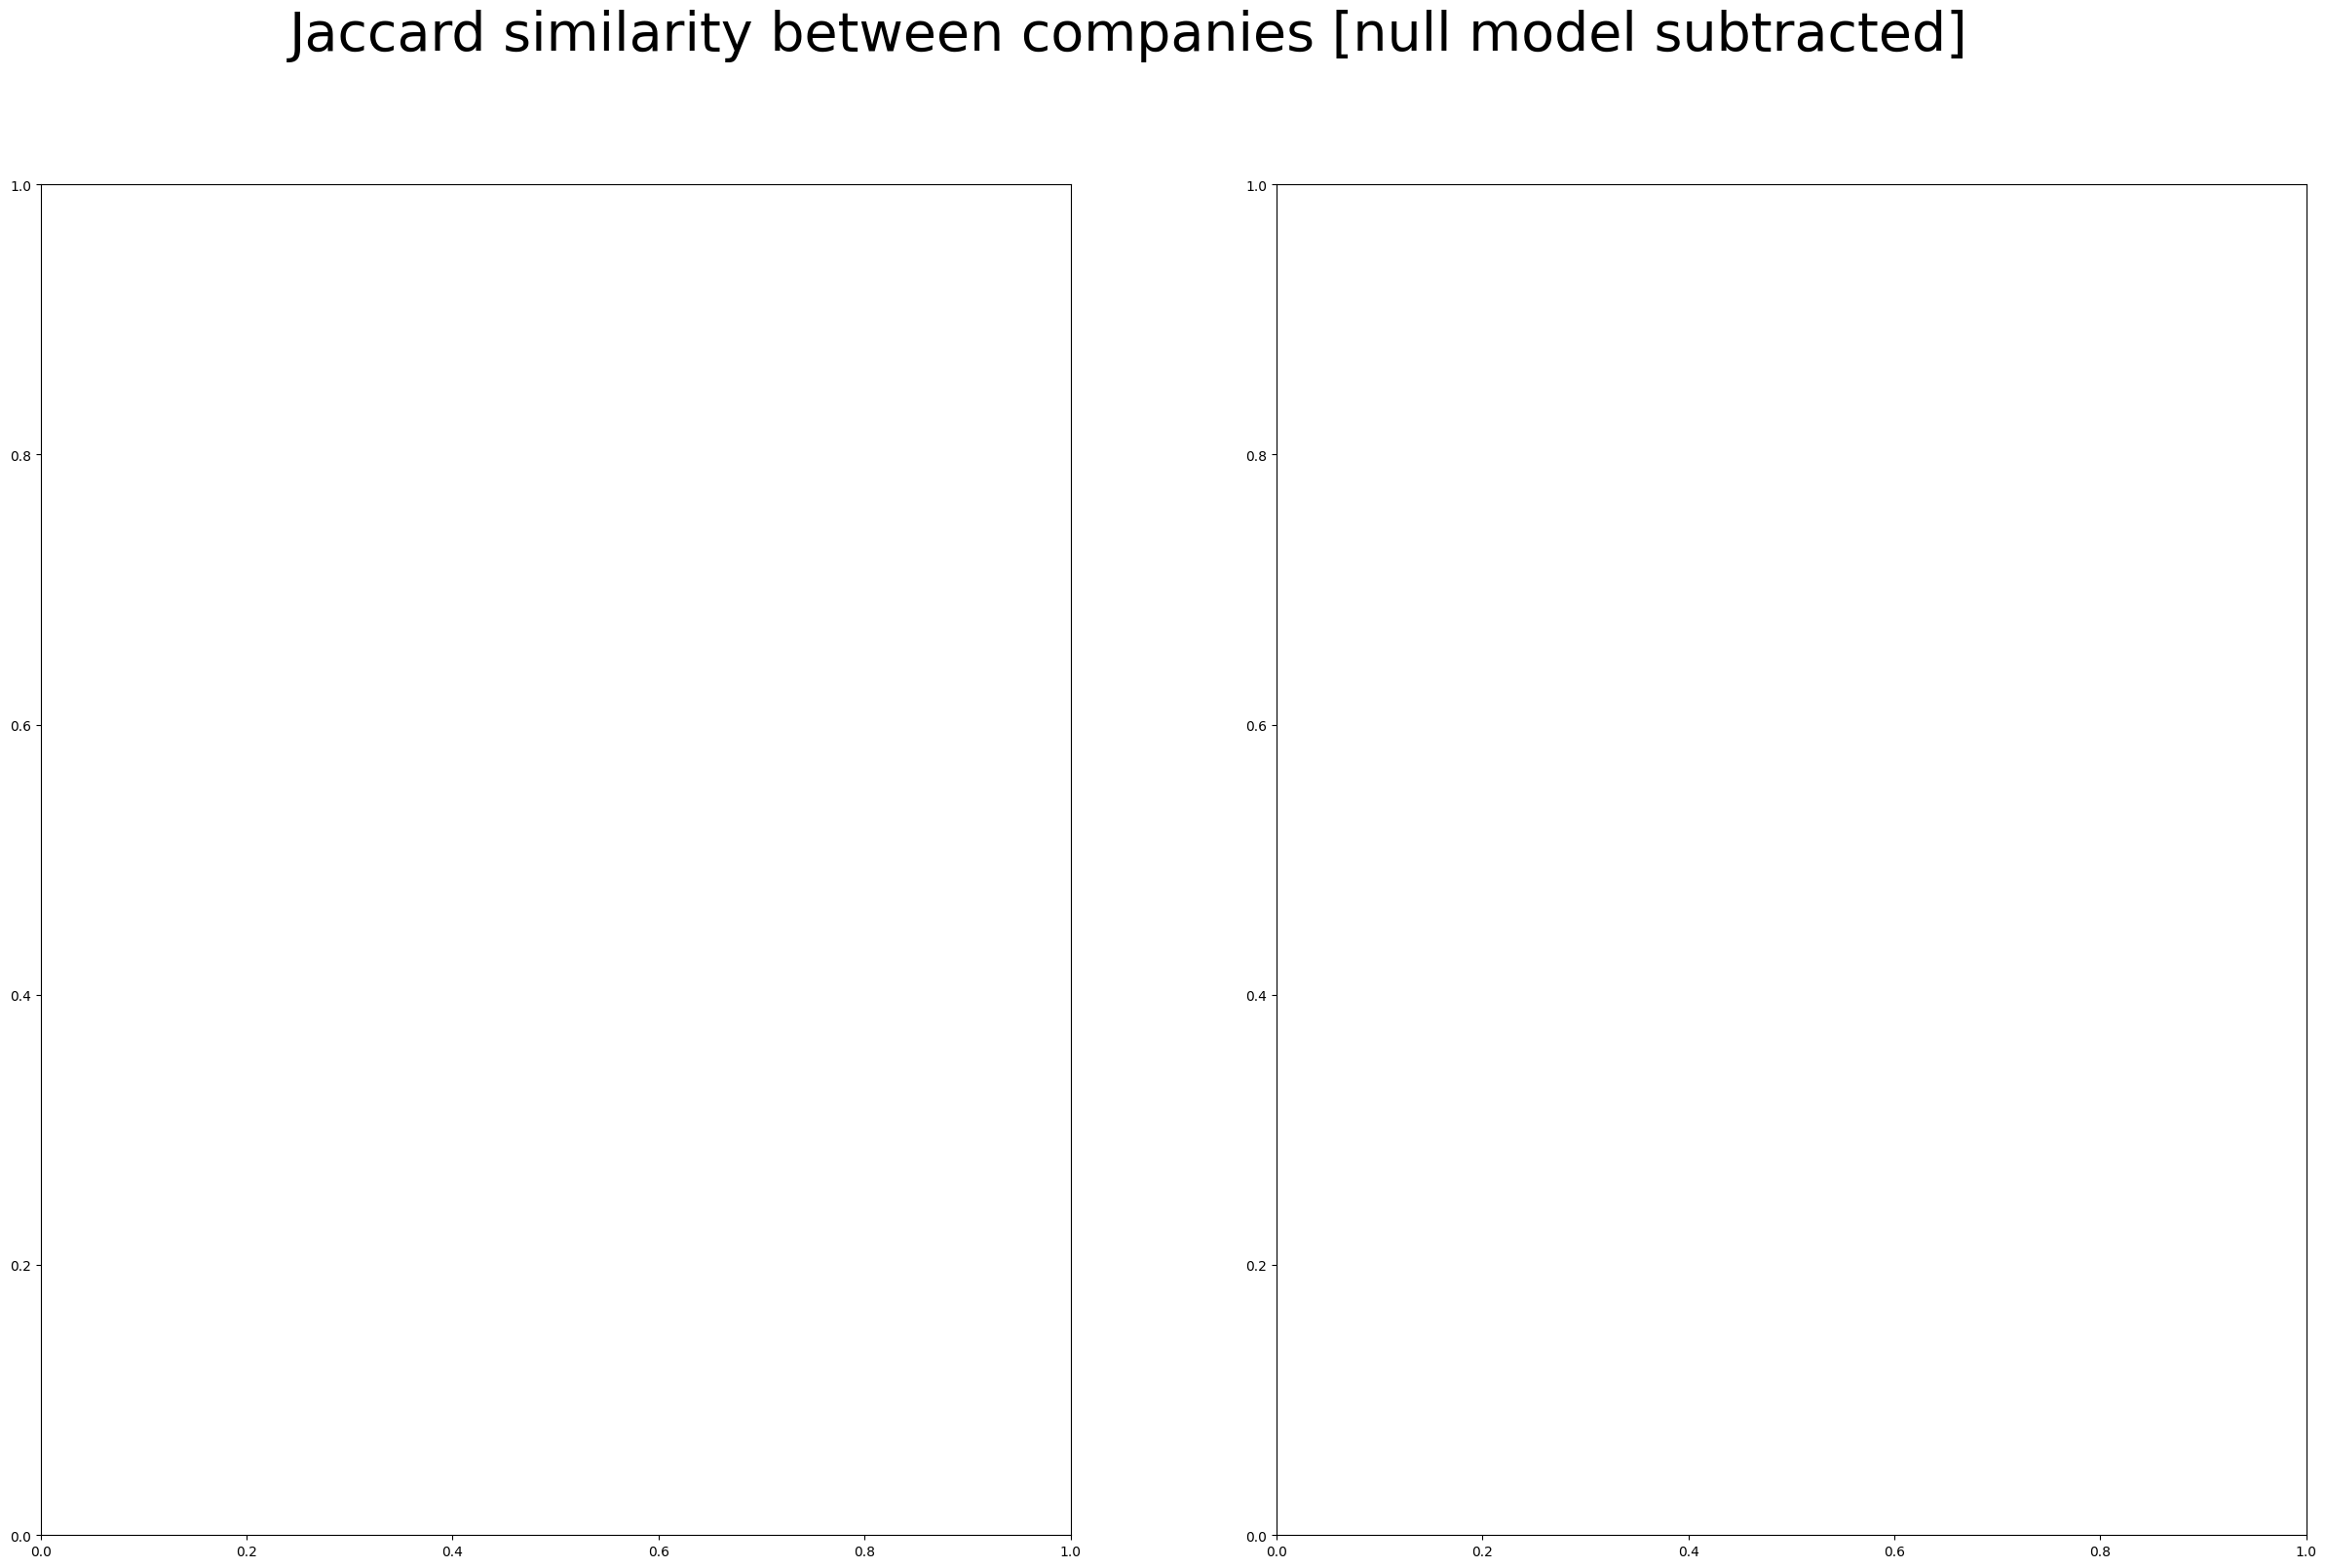

In [15]:
# Initialize the variables
raw_similarities, similarites, null_models = dict(), dict(), dict()

# Initalize the graphical panel
fig, axs = plt.subplots(nrows = 1, ncols = len(matrices), figsize = (30, 18))
fig.suptitle('Jaccard similarity between companies' + (' [null model subtracted] ' if subtract_nullModel else ''), fontsize = 40)#, y = 1.02)

for idk, (method, matrix) in enumerate(matrices.items()):
    print("METHOD:", method + '-based')

    #print("TOP20 REPORTED CATEGORIES:")
    #reportedCategory_matrix_stats = matrix.sum(axis = 0).sort_values(ascending = False).rename('Frequency')
    #display(reportedCategory_matrix_stats.head(20))

    # Find most reported categories
    topk = 5
    topReported_elements = dict.fromkeys(matrix.index)
    for company, reportedElements in matrix.to_dict(orient = 'index').items():
        elements = dict(sorted(reportedElements.items(), key = lambda category: category[1], reverse = True))
        topReported_elements[company] = ' - '.join([f'{element} (x{count})' for element, count in elements.items()][:topk])
    topReported_elements = pd.Series(topReported_elements).rename('Top reported categories')
    
    # Compute the jaccard similarity matrix
    matrix = matrix.applymap(lambda counter: True if counter > 0 else False)
    #reportedElement_similarities = 1 - pairwise_distances(matrix.to_numpy(), metric = 'jaccard')
    #reportedElement_similarities = pairwise_distances(matrix.to_numpy(), metric = jaccard_score)
    reportedElement_similarities = pairwise_distances(matrix.to_numpy(), metric = compute_jaccard_sim)
    
    jaccardSim_reportedElements = pd.DataFrame(data = reportedElement_similarities, index = matrix.index, columns = matrix.index)
    
    # Compute the null model
    if subtract_nullModel:
        jaccardSim_nullModel, companyDegrees = compute_similarity_nullModel(matrix)
        
        # Reorder the null matrix
        _, ordered_indices, _ = reorder_matrix(jaccardSim_nullModel.to_numpy())
        jaccardSim_nullModel = jaccardSim_nullModel.iloc[ordered_indices, ordered_indices]
        null_models[method] = jaccardSim_nullModel
        
        # Subtract
        jaccardSim_reportedElements = jaccardSim_reportedElements.subtract(jaccardSim_nullModel)
        
    # Reorder the matrix
    _, ordered_indices, _ = reorder_matrix(jaccardSim_reportedElements.to_numpy())
    jaccardSim_reportedElements = jaccardSim_reportedElements.iloc[ordered_indices, ordered_indices]
    raw_similarities[method] = jaccardSim_reportedElements
    
    # Set the diagonal to NaN (i.e., company-self similarity)
    np.fill_diagonal(jaccardSim_reportedElements.to_numpy(), val = np.NaN)
    
    # Find the most similar company for each company
    max_simScore = jaccardSim_reportedElements.max(axis = 1, skipna = True).rename('Max Jaccard similarity')
    most_simCompanies = jaccardSim_reportedElements.apply(func = lambda row: row.sort_values(ascending = False).round(2).iloc[:10].to_dict(), axis = 1)  # type: ignore
    
    companySectors = company_info['Sector']
    companySectors.index = companySectors.index.str.lower()
    most_simSectors = most_simCompanies.map(lambda dict_row: dict(Counter([companySectors[company.lower()] for company, score in dict_row.items()]).most_common(5))).rename('Most similar sector')
    
    most_simCompanies = most_simCompanies.map(lambda dict_row: ' - '.join([f'{company} ({score})' for company, score in dict_row.items()])).rename('Most similar companies')
    
    
    #company_info.loc['Adidas AG', 'Sector']
    
    # Save the results
    similarites[method] = pd.concat([topReported_elements, max_simScore, most_simCompanies, most_simSectors], axis = 1).sort_values(by = 'Max Jaccard similarity', ascending = False)
    display(similarites[method])
    
    heatmap_companies = max_simScore.sort_values(ascending = False).index[:30]
    jaccardSim_reportedElements = jaccardSim_reportedElements.loc[heatmap_companies, heatmap_companies]
    
    # [GRAPH] Visualize the similarity 
    sns.heatmap(jaccardSim_reportedElements, ax = axs[idk], cmap = "crest", vmin=None, vmax=None, linewidth = .5, cbar_kws={"shrink": .6, "location": 'top', 'pad': -0.05},
                mask = np.triu(np.ones_like(jaccardSim_reportedElements)))#'pad': -0.1},
    axs[idk].set_title(f"Based on the ESG-related {method} reported", fontsize = 25, color = 'midnightblue', y = 1.15)
    axs[idk].set_xlabel("Company", fontsize = 30, color = 'midnightblue')
    axs[idk].tick_params(axis = 'both', which = 'major', labelsize = 15, )#
    labelcolor = 'midnightblue'
    
    if idk == 0:
        axs[idk].set_ylabel("Company", fontsize = 30, color = 'midnightblue')

fig.tight_layout(h_pad = 30)
file_name = 'jaccardSimilarities_subtractNullModel.png' if subtract_nullModel else 'jaccardSimilarities.png'
fig.savefig(path.join(saving_folder, file_name), bbox_inches="tight", pad_inches=0.5)
plt.show()

## Save the null model

In [ ]:
if len(null_models.keys()) > 0:

    fig, axs = plt.subplots(nrows = 1, ncols = len(matrices), figsize = (20, 12))
    fig.suptitle('[Null model] Jaccard similarity between companies', fontsize = 40, y = 1.01)

    most_simCompanies = dict()
    for idk, (method, null_matrix) in enumerate(null_models.items()):
        
        # [GRAPH] Visualize the similarity 
        sns.heatmap(null_matrix, xticklabels = null_matrix.index,  yticklabels = null_matrix.columns, 
                    ax = axs[idk], cmap = "crest", vmin=None, vmax=None, linewidth = .5, cbar_kws={"shrink": .6, "location": 'top'}) 
                    #mask = np.triu(np.ones_like(null_matrix)))
        
        # Graphical setting
        axs[idk].set_title(f"Based on the ESG-related {method} reported", fontsize = 25, color = 'midnightblue', y = 1.18)
        axs[idk].set_xlabel("Company", fontsize = 20, color = 'midnightblue')
        if idk == 0:
            axs[idk].set_ylabel("Company", fontsize = 20, color = 'midnightblue')
        
        # Compute the most similar companies
        np.fill_diagonal(null_matrix.to_numpy(), val = np.NaN)
        similar_companies_df = null_matrix.apply(func = lambda row: row.sort_values(ascending = False).round(2).iloc[:5].to_dict(), axis = 1) # type: ignore
        most_simCompanies[method] = similar_companies_df.map(lambda dict_row: ' - '.join([f'{company} ({score})' for company, score in dict_row.items()])).rename('Most similar companies')

    # Save the graph
    fig.tight_layout(h_pad = 30)
    fig.savefig(path.join(saving_folder, f'jaccardNullSimilarities.png'), bbox_inches="tight", pad_inches=0.5)
    plt.show()

    # Save similar companies
    with pd.ExcelWriter(path.join(saving_folder, f'jaccardNullSimilarities.xlsx')) as writer:
        for method, most_simCompanies in most_simCompanies.items():
            most_simCompanies.to_excel(writer, sheet_name = method)
        pd.Series(companyDegrees).sort_values(ascending = False).to_excel(writer, sheet_name = 'Company degrees')
else:
    print("There are no null models to save")

# Company stats

In [ ]:
stats = defaultdict(list)
for idk, company in enumerate(df['company'].unique()):
    subset = df[df['company'] == company]
    
    print('\n' + "-" * 15,f'({idk + 1})' , company, "-" * 15)
    
    # Visualize the number of triples per category
    for col in subset.columns[1:]:
        companyStat = subset[col].value_counts()
        stats[company].append(companyStat)
        
        print(f'{col.upper()}: {len(subset[col].unique())}')
        #display(companyStat.head(25).to_frame())

## Saving findings

In [ ]:
infos = pd.Series(
    data = {
        'companies': df['company'].unique().size,
        'categories': df['category'].unique().size,
        'predicates': df['predicate'].unique().size,
        'triples': df.shape[0],
        'null_model': 'Subtracted' if subtract_nullModel else 'Not subtracted'}, 
    name = 'Dataset statistics')

# Save stats
with pd.ExcelWriter(path.join(saving_folder, '..', 'companyTriples_stats.xlsx')) as writer:  
    for company, stat in stats.items():
        for stat_col in stat:
            stat_col.rename('Frequency').to_excel(writer, sheet_name = f'{company[:10]}_{stat_col.name}')

file_name = 'rawJaccardSimilarities' + ('_subtractNullModel' if subtract_nullModel else '') + '.xlsx'
with pd.ExcelWriter(path.join(saving_folder, file_name)) as writer:  
    for method, raw_similarity in raw_similarities.items():
        raw_similarity.to_excel(writer, sheet_name = method)
    
# Save actions
file_name = 'jaccardSimilarities' + ('_subtractNullModel' if subtract_nullModel else '') + '.xlsx'
with pd.ExcelWriter(path.join(saving_folder, file_name)) as writer: 
    for method, jaccard_similarites in similarites.items():
        jaccard_similarites.to_excel(writer, sheet_name = f'{method.capitalize()}-based')
    infos.to_frame().to_excel(writer, sheet_name = 'infos')
    

# Similarities as graph

In [ ]:
# Define the colors
colormap = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99',]

sector_colors = {sector: colormap[idk].lower() for idk, sector in enumerate(sorted(company_info['Sector'].unique()))}
company_colors = {company.lower(): sector_colors[companySector] for company, companySector in company_info['Sector'].to_dict().items()}
display(sector_colors)

In [ ]:
def populate_graph(graph, adiacency_df):
    assert list(adiacency_df.index) == list(adiacency_df.columns), "Error"
      
    #display(adiacency_df.head(5))
    
    # Create the vertices 
    vnames = graph.new_vertex_property("string")
    vcolors = graph.new_vertex_property("string")
    for companyName in adiacency_df.index:
        v = graph.add_vertex()
        vnames[v] = companyName
        
        if companyName not in company_info.index:
            vcolors[v] = '#000000'
        else:
            vcolors[v] = colors[company_info.loc[companyName, 'Sector']]
        
    # Create the edges
    evalues = graph.new_edge_property("string")
    for ref_company, company_similarities in adiacency_df.iterrows():
        v1 = gt.find_vertex(graph, vnames, ref_company)[0]
        
        for company, company_similarity in company_similarities.dropna().round(2).items():
            v2 = gt.find_vertex(graph, vnames, company)[0]
            
            # Check if the edge already exists
            existing_edges = graph.edge(v2, v1, all_edges = True)
            if len(existing_edges) > 0:
                if any([True if float(evalues[edge]) == company_similarity else False for edge in existing_edges]):
                    continue

            # Create the edge
            e = graph.add_edge(v1, v2)
            evalues[e] = company_similarity
            
    return vnames, evalues, vcolors

def generate_violinPlot(df, visualize_outliers = False):

    fig = plt.figure(figsize = (30, 13))
    sns.violinplot(
        x = df, 
        orient = 'h',
        label = 'Degree distribution', 
        color = '#0288D1', # #EF5350', '#0288D1','#8BC34A'], 
        width = 0.9,
        alpha = .9, 
        linewidth = 6, 
        cut = 0, 
        scale = 'area') # , , area
    
    # Find outliers
    if visualize_outliers:
        df_stats = df.describe()
        low_outliers = df_stats.loc['25%'] - (df_stats.loc['75%'] - df_stats.loc['25%']) * 1.5 # type: ignore
        high_outliers = df_stats.loc['75%'] + (df_stats.loc['75%']  - df_stats.loc['25%']) * 1.5 # type: ignore
        outliers = df[(df < low_outliers) | (df > high_outliers)]
        print('Low outliers: ', round(low_outliers, 2), '\nHigh outliers: ', round(high_outliers, 2), '\n')
        
        # Plot outliers
        sns.scatterplot(x = outliers, y = 0, marker='o', color='white', alpha = .5, s = 20) # linewidth  = .1
    
    # Plot mean and median
    plt.axvline(df.median(), color = 'black', linestyle = 'dashed', linewidth = 4, 
                label = 'Median similarity (' + str(round(df.median() * 100, 1)) + ' %)')
    #plt.axvline(df.mean(), color = 'dimgrey', linestyle = 'dashdot', linewidth = 4, label = 'Average similarity (' + str(round(df.mean() * 100, 1)) + ' %)')
    
    # Axes labels
    plt.xlabel('Pairwise similarity', fontsize = 40, labelpad = 20)
    plt.ylabel(f"Companies", fontsize = 40)

    # Axes ticks
    plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals = 0))
    plt.xticks(fontsize = 30, alpha = .8)
    
    # General graphical settings
    plt.legend(fontsize = 35)
    plt.tight_layout(pad = 2)

    # Save the figure
    plt.savefig(path.join(saving_folder, f'{df.name}SimilarityDistribution.pdf'))
    plt.close()

In [ ]:
save_graphs = True
#plt.switch_backend("cairo")
#plt.switch_backend("TkAgg")

In [ ]:
adiacency_thresholds = {
    'categories': 0.5,
    'actions': 0.06
}

In [ ]:
edge_lists = dict()
for method, jaccard_similarites in raw_similarities.items():
    print('-' * 50, method.upper(), '-' * 50)
    
    edge_list = jaccard_similarites.to_dict(orient = 'index')
    edge_lists[method] = [(companyA, companyB, np.round(similarity * 100, 1)) for companyA, companies in edge_list.items() for companyB, similarity in companies.items() if similarity >= adiacency_thresholds[method] and companyA != companyB]

In [ ]:
for method, jaccard_similarites in raw_similarities.items():
    print('-' * 50, method.upper(), '-' * 50)

    # NUMERICAL DISTRIBUTION (violin plot)
    stats = pd.Series(jaccard_similarites.to_numpy().flatten(), name = method)
    display(stats.describe().round(4).to_frame().T)
    generate_violinPlot(stats)

for method, edge_list in edge_lists.items():
    
    unique_companies= np.unique([companyA for companyA, _, _ in edge_lists[method]] + [companyB for _, companyB, _ in edge_lists[method]])
    #display(unique_nodes)
    unique_companies = [(company, {'color': company_colors[company.lower()]}) for company in unique_companies]
    
    graph = nx.Graph()
    
    #companyColors
    graph.add_nodes_from(unique_companies)
    graph.add_weighted_edges_from(edge_list)

    nx.write_gexf(graph, path = path.join(saving_folder, f'{method}companySimilarities.gexf'), version = '1.2draft')
    
    #postfixes = ['inc','ltd','corp', 'corporation', 'group', 'co','company', 'ag', 'nv','plc', 'sa', 'spa']
    #for idk, vname in enumerate(graph.nodes()):
    #    unique_nodes[idk] = ' '.join([word for word in vname.split(' ')[:3] if word.lower() not in postfixes]) 
    
    fig = plt.figure(figsize = (10, 10))
    nx.draw(graph, 
            #pos = nx.spring_layout(graph, k = 0.5, iterations = 50, seed = 42), # nx.bipartite_layout(graph, unique_companies, align = 'horizontal'
            pos = nx.kamada_kawai_layout(graph, weight = 'weight', scale = 1.5),
            node_color = [ company_colors[node.lower()] for node in graph.nodes()], 
            with_labels = False,  
            alpha = 0.9, 
            node_size = [80 + (degree * 500) for degree in nx.degree_centrality(graph).values()], 
            width = 1) # 
    #  pos = bipartite_positions, node_color = [all_node_colors[node] for node in community_graph.nodes()],
    #node_size = [v * 100 for v in community_degrees.values()]
    
    plt.legend([Line2D([0], [0], color = colour, lw = 5) for colour in sector_colors.values()], sector_colors.keys(), title = 'Sectors', fontsize = 6, title_fontsize = 8, borderpad = 1) # loc = 'upper right'
    plt.savefig(path.join(saving_folder, f'{method}SimilarityGraph.pdf'))
    plt.show()
    

In [ ]:
for method, jaccard_similarites in raw_similarities.items():
    print('-' * 50, method.upper(), '-' * 50)

    # NUMERICAL DISTRIBUTION (violin plot)
    stats = pd.Series(jaccard_similarites.to_numpy().flatten(), name = method)
    display(stats.describe().round(4).to_frame().T)
    generate_violinPlot(stats)
    
    #display(jaccard_similarites[jaccard_similarites >= adiacency_thresholds[method]])
    
    # GRAPH REPRESENTATION
    graph = gt.Graph(directed = False)
    
    # Create the names for the nodes and edges
    vnames, evalues, vcolors = populate_graph(graph, adiacency_df = jaccard_similarites)
    
    # Turnaround to avoid the long names
    postfixes = ['inc','ltd','corp', 'corporation', 'group', 'co','company', 'ag', 'nv','plc', 'sa', 'spa']
    for idk, vname in enumerate(vnames):
        vnames[idk] = ' '.join([word for word in vname.split(' ')[:3] if word.lower() not in postfixes])

    # Create a partial view of the graph by filtering the edges
    similarity_graph = gt.GraphView(graph,  efilt = lambda e: float(evalues[e]) >= adiacency_thresholds[method])
    similarity_graph = gt.GraphView(similarity_graph,  vfilt = lambda v: v.out_degree() > 0)
    if similarity_graph.num_vertices() == 0:
        print('No Vertex found!',similarity_graph)
        continue
    else:
        print("[VIEW] VERTICES:", similarity_graph.num_vertices(), ", EDGES:", similarity_graph.num_edges())
    
    # View 2: Connected graph
    fig, ax = plt.subplots(1, 1, figsize=(150, 150))
    
    # View 2: Legend
    ax.legend([Line2D([0], [0], color = colour, lw = 60) for colour in colors.values()], colors.keys(), fontsize = 60, title = 'Sectors', title_fontsize = 8, borderpad = 1) # loc = 'upper right'
    
    # View 2: Graph
    gt.graph_draw(
        g = similarity_graph, 
        #pos = gt.arf_layout(similarity_graph, d = 2, a = 1), # root = similarity_graph.get_vertices()[highest_degree_vertex]
        pos = gt.sfdp_layout(similarity_graph, mu = 10, C = 1, r = 0.3, K = 20),
        vertex_text = vnames, 
        edge_text = evalues,
        #vertex_color = vcolors, #[vcolors[vertex] for vertex in similarity_graph.get_vertices()],
        vertex_fill_color = 'black',
        #bg_color = 'white', 
        #output_size = (100, 100),
        #output = path.join(saving_folder, f'{method}SimilarityGraph.png') if save_graphs else None,
        mplfig = ax,
        #vertex_font_size = 10, edge_font_size = 10, 
        #edge_pen_width = 100,
        vprops = dict(font_size = 1, pen_width = 0), # halo = True, halo_color = vcolors, color = 'white'
        eprops = dict(font_size = 1, marker_size = 1, pen_width = 1, color = 'black')
    )
    fig.tight_layout()
    fig.savefig(path.join(saving_folder, f'{method}SimilarityGraph.pdf'))
    plt.close()

In [ ]:
# Nested stochastic block model,
#state = gt.minimize_nested_blockmodel_dl(similarity_graph, state_args = dict(deg_corr =  False)) # 
#state = gt.minimize_blockmodel_dl(similarity_graph)

# View 1: Nested block model
#gt.draw_hierarchy(
#    state = state,
#    vertex_text = vnames, edge_text = evalues, vertex_color = vcolors,
#    output_size = (10000, 10000),
#    bg_color = 'white',
#    output = path.join(saving_folder, f'{method}NestedBlockmodel.png') if save_graphs else None,
#    edge_font_size = 70,
#    vprops = dict(size = 150, color = 'black'),
#    eprops = dict(marker_size = 50, color = 'black', pen_width = 50, font_size = 50))

#highest_degree_vertex = np.argsort(similarity_graph.degree_property_map('total').a)[0]

#gt.graph_draw(
#    g = similarity_graph, 
#    bg_color = 'white',
#    edge_pen_width=1,
#    vertex_text=vnames,
#    edge_text=evalues,
#    vertex_aspect=1, 
#    vertex_text_position=1, 
#    vertex_text_color='black',
#    vertex_font_size=11,
#    #vertex_font_weight=cairo.FONT_WEIGHT_NORMAL,
#    vertex_color=None,
#    vertex_size=8
#  )